[View in Colaboratory](https://colab.research.google.com/github/nakamura41/emotion_detection_notebooks/blob/master/EmoInt_Sentiment_Analysis_LSTM_ConvNet.ipynb)

In [1]:
!pip install gensim
!pip install -U -q PyDrive

    100% |████████████████████████████████| 23.5MB 1.8MB/s 
    100% |████████████████████████████████| 1.4MB 13.3MB/s 
    100% |████████████████████████████████| 133kB 24.0MB/s 
    100% |████████████████████████████████| 61kB 19.3MB/s 
    100% |████████████████████████████████| 4.7MB 857kB/s 
    100% |████████████████████████████████| 552kB 21.7MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/73/f1/9b/ccf93d4ba073b6f79b1ed9df68ab5ce048d8136d0efcf90b30
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [2]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import urllib.request
import pandas as pd
from gensim.test.utils import common_texts, get_tmpfile
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from tempfile import gettempdir
import zipfile
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

1.10.1


Using TensorFlow backend.


In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# download google drive file
def download_drive_file(drive_directory, filename):
  list_file_query = "title='{}' and trashed=false".format(drive_directory)
  file_list = drive.ListFile({'q': list_file_query}).GetList()

  if len(file_list) > 0:
    directory_id = file_list[0]['id']

    list_file_query = "'{}' in parents".format(directory_id)

    file_list = drive.ListFile({'q': list_file_query}).GetList()
    
    file_id = None
    for file1 in file_list:
      if file1['title'] == filename:
        print("downloading file {}".format(file1['title']))
        file1.GetContentFile(file1['title'])

In [5]:
download_drive_file("Datasets", "GoogleNews-vectors-negative300.bin.gz")

downloading file GoogleNews-vectors-negative300.bin.gz


In [6]:
!ls

adc.json  GoogleNews-vectors-negative300.bin.gz  sample_data


In [0]:
class EmoIntDataset(object):
  BASE_URL = "http://saifmohammad.com/WebDocs/"
  TRAIN_URI = "EmoInt%20Train%20Data/{}-ratings-0to1.train.txt"
  TEST_URI = "EmoInt%20Test%20Data/{}-ratings-0to1.test.target.txt"
  EMOTION_CLASSES = ["anger", "fear", "joy", "sadness"]
  
  def __load_data_per_class(self, url):
    resource = urllib.request.urlopen(url)
    np_array = np.asarray([line.split('\t') for line in [line.strip() for line in resource.read().decode('utf-8').splitlines()]])
    df = pd.DataFrame(np_array, columns=["id", "text", "emotion", "emotion_level"])
    return df[["text", "emotion"]]
  
  def load_data(self):
    train_data = None
    test_data = None
    
    for emotion in self.EMOTION_CLASSES:
      # load train dataset
      train_df = self.__load_data_per_class(self.BASE_URL + self.TRAIN_URI.format(emotion))
      
      # load test dataset
      test_df = self.__load_data_per_class(self.BASE_URL + self.TEST_URI.format(emotion))
      
      train_data = (train_df if train_data is None else train_data.append(train_df))
      test_data = (test_df if test_data is None else test_data.append(test_df))
      
    return train_data, test_data

In [8]:
emo_int_dataset = EmoIntDataset()
train_data, test_data = emo_int_dataset.load_data()

val_data=train_data.sample(frac=0.1,random_state=200)
train_data=train_data.drop(val_data.index)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(2463, 2)
(361, 2)
(3142, 2)


In [9]:
emotions = train_data.emotion.unique()
dic = dict()
labels = []
for i, emotion in enumerate(emotions):
    dic[emotion]=i
    labels.append(emotion)
print(dic)
print(labels)

{'anger': 0, 'fear': 1, 'joy': 2, 'sadness': 3}
['anger', 'fear', 'joy', 'sadness']


In [10]:
NUM_WORDS=20000
texts = train_data.text
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)
tokenizer.fit_on_texts(texts)
sequences_train = tokenizer.texts_to_sequences(texts)
sequences_valid = tokenizer.texts_to_sequences(val_data.text)
sequences_test = tokenizer.texts_to_sequences(test_data.text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8479 unique tokens.


In [11]:
X_train = pad_sequences(sequences_train)
X_val = pad_sequences(sequences_valid, maxlen=X_train.shape[1])
X_test = pad_sequences(sequences_test, maxlen=X_train.shape[1])

y_train = to_categorical(np.asarray(train_data.emotion.apply(lambda x:dic[x])))
y_val = to_categorical(np.asarray(val_data.emotion.apply(lambda x:dic[x])))
y_test = to_categorical(np.asarray(test_data.emotion.apply(lambda x:dic[x])))

print('Shape of X train, validation and test tensor:', X_train.shape, X_val.shape, X_test.shape)
print('Shape of label train, validation and test tensor:', y_train.shape, y_val.shape, y_test.shape)

Shape of X train, validation and test tensor: (2463, 34) (361, 34) (3142, 34)
Shape of label train, validation and test tensor: (2463, 4) (361, 4) (3142, 4)


In [0]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

EMBEDDING_DIM=300
vocabulary_size = min(len(word_index)+1, NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25), EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

In [49]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout, concatenate, LSTM
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = X_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length, EMBEDDING_DIM, 1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)
dropout = Dropout(drop)(flatten)
reshape2 = Reshape((1, 3 * num_filters))(dropout)
lstm = LSTM(3 * num_filters)(reshape2)
output = Dense(units=4, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(lstm)

# this creates a model that includes
model = Model(inputs, output)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 300)      2544000     input_5[0][0]                    
__________________________________________________________________________________________________
reshape_7 (Reshape)             (None, 34, 300, 1)   0           embedding_1[4][0]                
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 1, 100)   90100       reshape_7[0][0]                  
__________________________________________________________________________________________________
conv2d_14 

In [50]:
adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
history = model.fit(X_train, y_train, batch_size=1000, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks=callbacks)  # starts training

Train on 2463 samples, validate on 361 samples
Epoch 1/100
2463/2463 [==============================] - 3s 1ms/step - loss: 1.5008 - acc: 0.3264 - val_loss: 1.4496 - val_acc: 0.3490
Epoch 2/100
2463/2463 [==============================] - 0s 159us/step - loss: 1.3763 - acc: 0.3788 - val_loss: 1.3146 - val_acc: 0.4072
Epoch 3/100
2463/2463 [==============================] - 0s 134us/step - loss: 1.1528 - acc: 0.5713 - val_loss: 1.1285 - val_acc: 0.6953
Epoch 4/100
2463/2463 [==============================] - 0s 138us/step - loss: 0.9001 - acc: 0.8664 - val_loss: 0.9636 - val_acc: 0.8227
Epoch 5/100
2463/2463 [==============================] - 0s 135us/step - loss: 0.6827 - acc: 0.9631 - val_loss: 0.8188 - val_acc: 0.8532
Epoch 6/100
2463/2463 [==============================] - 0s 128us/step - loss: 0.4948 - acc: 0.9846 - val_loss: 0.7449 - val_acc: 0.8643
Epoch 7/100
2463/2463 [==============================] - 0s 134us/step - loss: 0.3973 - acc: 0.9878 - val_loss: 0.7652 - val_acc: 0.8

In [0]:
model_path = 'emoint_model.h5'
weight_path = 'emoint_weights.h5'

model.save(model_path)
model.save_weights(weight_path)

In [52]:
!ls -lah

total 1.6G
drwxr-xr-x 1 root root 4.0K Sep 13 06:38 .
drwxr-xr-x 1 root root 4.0K Sep 13 06:31 ..
-rw-r--r-- 1 root root 2.5K Sep 13 06:33 adc.json
drwxr-xr-x 1 root root 4.0K Sep 13 06:33 .config
-rw-r--r-- 1 root root  42M Sep 13 06:43 emoint_model.h5
-rw-r--r-- 1 root root  14M Sep 13 06:43 emoint_weights.h5
-rw-r--r-- 1 root root 1.6G Sep 13 06:33 GoogleNews-vectors-negative300.bin.gz
drwxr-xr-x 2 root root 4.0K Sep 11 17:54 sample_data


In [0]:
model_file = drive.CreateFile({'title': model_path})
model_file.SetContentFile(model_path)
model_file.Upload()

weight_file = drive.CreateFile({'title': weight_path})
weight_file.SetContentFile(weight_path)
weight_file.Upload()

In [0]:
sequences_test=tokenizer.texts_to_sequences(test_data.text)
X_test = pad_sequences(sequences_test, maxlen=X_test.shape[1])
y_pred = model.predict(X_test)

In [55]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [0]:
y_pred_original = [labels[val] for val in np.argmax(y_pred, axis=1).squeeze()]
y_test_original = np.asarray(test_data.emotion)

In [0]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=15):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [58]:
cf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=labels)

df_cm = pd.DataFrame(
    cf_matrix, index=labels, columns=labels, 
)

df_cm

,anger,fear,joy,sadness
anger,626,44,17,73
fear,58,778,21,138
joy,21,31,606,56
sadness,29,51,12,581


Figure(288x216)


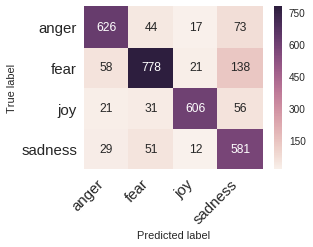

In [59]:
print(print_confusion_matrix(cf_matrix, class_names=labels))

In [60]:
test_accuracy = accuracy_score(y_test_original, y_pred_original)
print("test accuracy:", test_accuracy)

test accuracy: 0.8246339910884787


### Performance score for each classes

In [61]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support.round(4)
}
score_df = pd.DataFrame(score_dict, index=labels)
score_df

,f1-score,precision,recall,support
anger,0.8380,0.8529,0.8237,760
fear,0.8194,0.8606,0.7819,995
joy,0.8847,0.9238,0.8487,714
sadness,0.7640,0.6851,0.8633,673


### Performance score using micro average

In [62]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="micro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,f1-score,precision,recall,support
score,0.8246,0.8246,0.8246,None


### Performance score using macro average

In [63]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="macro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,f1-score,precision,recall,support
score,0.8265,0.8306,0.8294,None


### Performance score using weighted average

In [64]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="weighted")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,f1-score,precision,recall,support
score,0.8269,0.8355,0.8246,None
